In [1]:
import mitsuba
mitsuba.set_variant("packet_spectral")
from mitsuba.render import Histogram
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_spectogram, fractionalOctaves, SOUND_SPEED

In [2]:
def decay(x, slope):
    return 1 / (x + slope) * slope

def generate_decaying_samples(n_samples, n_features):
    x = np.linspace(0, 1, n_samples)
    x = (np.tile(x, (n_features, 1)) * np.logspace(0, 1, n_features)[np.newaxis].transpose()).transpose()
    x = decay(x, np.random.uniform(size=(n_samples, n_features)))
    return x

### Linear binning (uniform sampling)

In [3]:
n_samples = 10000
n_time_steps = 50
n_bins = 10
wav_range = [0.017, 17] # meters
time_range = [0, 10] # seconds

hist = Histogram(bin_count=n_bins, time_step_count=n_time_steps, wav_range=wav_range, time_range=time_range)

spectrum = np.ones(shape=(n_samples, 4)) # generate_decaying_samples(n_samples, 4)
wavelength = np.random.uniform(wav_range[0], wav_range[1], size=(n_samples, 4))
time = np.sort(np.random.uniform(time_range[0], time_range[1], size=(n_samples, )))

hist.clear()
valid = hist.put(time, wavelength, spectrum)

assert np.all(valid)

TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. mitsuba.render.Histogram(time_step_count: int, time_range: enoki.scalar.Vector2f, wavelength_bins: List[float])

Invoked with: kwargs: bin_count=10, time_step_count=50, wav_range=[0.017, 17], time_range=[0, 10]

In [4]:
plot_spectogram(hist)

NameError: name 'hist' is not defined

## Fractional Octave binning (pdf sampling)

In [5]:
center, low, high, _ = fractionalOctaves(1)

In [12]:
# Glue together the bins
bins = np.concatenate(([low[0]],high))
bins_wav = np.flip(SOUND_SPEED / bins)
center_wav = np.flip(SOUND_SPEED / center)
print(bins_wav)

[ 0.01532125  0.03056991  0.06099498  0.12170099  0.2428254   0.48450038
  0.96670535  1.92883075  3.8485233   7.67881351 15.32124721]


In [7]:
all_freq = np.concatenate((low, center, high))
all_freq = np.unique(np.sort(all_freq.round(decimals=10)))
all_freq_wav = np.flip(SOUND_SPEED / all_freq)

In [8]:
def fractionalOctaveBin(f_high, f):
    #return np.argmax(f_high > f, axis=0)
    return np.searchsorted(f_high, f)

In [9]:
from mitsuba.core import IrregularContinuousDistribution

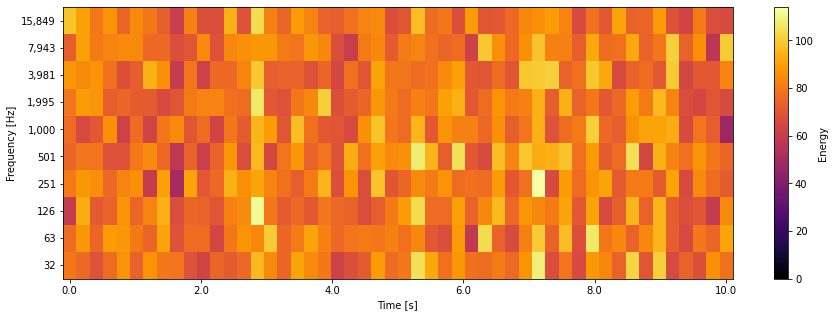

In [10]:
n_samples = 10000
n_time_steps = 50
time_range = [0, 10] # seconds

hist2 = Histogram(time_step_count=n_time_steps, time_range=time_range, wavelength_bins=bins_wav)
hist3 = Histogram(time_step_count=n_time_steps, time_range=time_range, wavelength_bins=bins_wav)

# Sampling from continous distribution
d = IrregularContinuousDistribution(bins_wav, np.flip(bins / np.sum(bins)))
d2 = IrregularContinuousDistribution(all_freq_wav, np.flip(all_freq / np.sum(all_freq)))

uniform_samples = np.random.uniform(0, 1, size=(n_samples, 4))

distribution_samples = np.array([d.sample(x) for x in uniform_samples])
distribution_samples2 = np.array([d2.sample(x) for x in uniform_samples])

spectrum = np.ones(shape=(n_samples, 4))
wavelength = distribution_samples
wavelength2 = distribution_samples2
time = np.sort(np.random.uniform(time_range[0], time_range[1], size=(n_samples, )))

hist2.clear()
hist3.clear()

valid = hist2.put(time, wavelength, spectrum)
valid2 = hist3.put(time, wavelength2, spectrum)

assert np.all(valid) and np.all(valid2)
assert np.allclose(hist2.data(), hist3.data())
plot_spectogram(hist2, bins=center)